In [0]:
# Importing the necessary modules.
from pyspark.sql.functions import *
from IPython.core import alias
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
import matplotlib.pyplot as plt

In [0]:
# checking the spark session.
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.3.2 
 Master 
 local[8] 
 AppName 
 Databricks Shell

In [0]:
# reading the dataset into the dataframe.
df=spark.read.csv('/FileStore/tables/Copy_of_loan.csv',header=True,inferSchema=True)

In [0]:
# viewing the dataframe.
df.show()

+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
| Loan_ID|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|LP001002|  Male|     No|         0|    Graduate|           No|           5849|              0.0|      null|             360|             1|        Urban|          Y|
|LP001003|  Male|    Yes|         1|    Graduate|           No|           4583|           1508.0|       128|             360|             1|        Rural|          N|
|LP001005|  Male|    Yes|         0|    Graduate|          Yes|           3000|              0.0|        66|             360|             1|        Urban|          Y

In [0]:
# eliminating non necessary rows.
df=df.where(df['Dependents']!='3+')

In [0]:
# viewing the dataframe.
df.show()

+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
| Loan_ID|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|LP001002|  Male|     No|         0|    Graduate|           No|           5849|              0.0|      null|             360|             1|        Urban|          Y|
|LP001003|  Male|    Yes|         1|    Graduate|           No|           4583|           1508.0|       128|             360|             1|        Rural|          N|
|LP001005|  Male|    Yes|         0|    Graduate|          Yes|           3000|              0.0|        66|             360|             1|        Urban|          Y

In [0]:
# counting the total number of rows.
df.count()

Out[6]: 548

In [0]:
# droping the not so important columns.
df=df.drop(*['Loan_ID','Gender','Married','Self_Employed','Property_Area'])
df.show()

+----------+------------+---------------+-----------------+----------+----------------+--------------+-----------+
|Dependents|   Education|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Loan_Status|
+----------+------------+---------------+-----------------+----------+----------------+--------------+-----------+
|         0|    Graduate|           5849|              0.0|      null|             360|             1|          Y|
|         1|    Graduate|           4583|           1508.0|       128|             360|             1|          N|
|         0|    Graduate|           3000|              0.0|        66|             360|             1|          Y|
|         0|Not Graduate|           2583|           2358.0|       120|             360|             1|          Y|
|         0|    Graduate|           6000|              0.0|       141|             360|             1|          Y|
|         2|    Graduate|           5417|           4196.0|       267|          

In [0]:
# checking the datatypes of the columns.
df.dtypes


Out[8]: [('Dependents', 'string'),
 ('Education', 'string'),
 ('ApplicantIncome', 'int'),
 ('CoapplicantIncome', 'double'),
 ('LoanAmount', 'int'),
 ('Loan_Amount_Term', 'int'),
 ('Credit_History', 'int'),
 ('Loan_Status', 'string')]

In [0]:
# casting the datatype of the columns.
df=df.withColumn('Dependents',df.Dependents.cast('int'))
df=df.withColumn('LoanAmount ',df.LoanAmount.cast('double'))

In [0]:
# checking the datatypes of the columns.
df.dtypes

Out[10]: [('Dependents', 'int'),
 ('Education', 'string'),
 ('ApplicantIncome', 'int'),
 ('CoapplicantIncome', 'double'),
 ('LoanAmount', 'int'),
 ('Loan_Amount_Term', 'int'),
 ('Credit_History', 'int'),
 ('Loan_Status', 'string'),
 ('LoanAmount ', 'double')]

In [0]:
# checking the null values.
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----------+---------+---------------+-----------------+----------+----------------+--------------+-----------+-----------+
|Dependents|Education|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Loan_Status|LoanAmount |
+----------+---------+---------------+-----------------+----------+----------------+--------------+-----------+-----------+
|         0|        0|              0|                0|        18|              12|            47|          0|         18|
+----------+---------+---------------+-----------------+----------+----------------+--------------+-----------+-----------+



In [0]:
# objectizing the Imputer.
imputer_mode=Imputer(strategy='mode')
imputer_mean=Imputer(strategy='mean')

In [0]:
# setting the input columns.
imputer_mode.setInputCols(['Loan_Amount_Term','Credit_History'])
imputer_mean.setInputCol('LoanAmount')

Out[17]: Imputer_0882492d2166

In [0]:
# setting the output columns.
imputer_mode.setOutputCols(['Loan_Amount_Term_filled','Credit_History_filled'])
imputer_mean.setOutputCol('LoanAmount_filled')

Out[18]: Imputer_0882492d2166

In [0]:
# fitting the model.
model_mode=imputer_mode.fit(df)
model_mean=imputer_mean.fit(df)

In [0]:
# transforming the model.
df=model_mode.transform(df)

In [0]:
# transforming the model.
df=model_mean.transform(df)

In [0]:
# viewing the dataframe.
df.show()


+----------+------------+---------------+-----------------+----------+----------------+--------------+-----------+-----------+-----------------------+---------------------+-----------------+
|Dependents|   Education|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Loan_Status|LoanAmount |Loan_Amount_Term_filled|Credit_History_filled|LoanAmount_filled|
+----------+------------+---------------+-----------------+----------+----------------+--------------+-----------+-----------+-----------------------+---------------------+-----------------+
|         0|    Graduate|           5849|              0.0|      null|             360|             1|          Y|       null|                    360|                    1|              142|
|         1|    Graduate|           4583|           1508.0|       128|             360|             1|          N|      128.0|                    360|                    1|              128|
|         0|    Graduate|           3000|    

In [0]:
# droping the un-necessary columns.
df=df.drop(*['LoanAmount ','Loan_Amount_Term','Credit_History'])

In [0]:
# viewing the dataframe.
df.show()

+----------+------------+---------------+-----------------+----------+-----------+-----------------------+---------------------+-----------------+
|Dependents|   Education|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Status|Loan_Amount_Term_filled|Credit_History_filled|LoanAmount_filled|
+----------+------------+---------------+-----------------+----------+-----------+-----------------------+---------------------+-----------------+
|         0|    Graduate|           5849|              0.0|      null|          Y|                    360|                    1|              142|
|         1|    Graduate|           4583|           1508.0|       128|          N|                    360|                    1|              128|
|         0|    Graduate|           3000|              0.0|        66|          Y|                    360|                    1|               66|
|         0|Not Graduate|           2583|           2358.0|       120|          Y|                    360|            

In [0]:
# checking the null values.
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----------+---------+---------------+-----------------+----------+-----------+-----------------------+---------------------+-----------------+
|Dependents|Education|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Status|Loan_Amount_Term_filled|Credit_History_filled|LoanAmount_filled|
+----------+---------+---------------+-----------------+----------+-----------+-----------------------+---------------------+-----------------+
|         0|        0|              0|                0|        18|          0|                      0|                    0|                0|
+----------+---------+---------------+-----------------+----------+-----------+-----------------------+---------------------+-----------------+



In [0]:
# objectizing String indexer.
indexer=StringIndexer(inputCols=['Education','Loan_Status'], outputCols=['Education_numeric','Loan_Status_numeric'])

In [0]:
# fitting the model.
indexer_model=indexer.fit(df)

In [0]:
# transforming the model.
df=indexer_model.transform(df)

In [0]:
# viewing the dataframe.
df.show()

+----------+------------+---------------+-----------------+----------+-----------+-----------------------+---------------------+-----------------+-----------------+-------------------+
|Dependents|   Education|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Status|Loan_Amount_Term_filled|Credit_History_filled|LoanAmount_filled|Education_numeric|Loan_Status_numeric|
+----------+------------+---------------+-----------------+----------+-----------+-----------------------+---------------------+-----------------+-----------------+-------------------+
|         0|    Graduate|           5849|              0.0|      null|          Y|                    360|                    1|              142|              0.0|                0.0|
|         1|    Graduate|           4583|           1508.0|       128|          N|                    360|                    1|              128|              0.0|                1.0|
|         0|    Graduate|           3000|              0.0|        66|     

In [0]:
# droping the duplicated old columns.
df=df.drop(*['Education','Loan_Status'])

In [0]:
# viewing the dataframe.
df.show()

+----------+---------------+-----------------+----------+-----------------------+---------------------+-----------------+-----------------+-------------------+
|Dependents|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term_filled|Credit_History_filled|LoanAmount_filled|Education_numeric|Loan_Status_numeric|
+----------+---------------+-----------------+----------+-----------------------+---------------------+-----------------+-----------------+-------------------+
|         0|           5849|              0.0|      null|                    360|                    1|              142|              0.0|                0.0|
|         1|           4583|           1508.0|       128|                    360|                    1|              128|              0.0|                1.0|
|         0|           3000|              0.0|        66|                    360|                    1|               66|              0.0|                0.0|
|         0|           2583|           2

In [0]:
# checking the datatypes of all the columns.
df.dtypes

Out[33]: [('Dependents', 'int'),
 ('ApplicantIncome', 'int'),
 ('CoapplicantIncome', 'double'),
 ('LoanAmount', 'int'),
 ('Loan_Amount_Term_filled', 'int'),
 ('Credit_History_filled', 'int'),
 ('LoanAmount_filled', 'int'),
 ('Education_numeric', 'double'),
 ('Loan_Status_numeric', 'double')]

In [0]:
# changing the datatype of the columns.
df=df.withColumn('CoapplicantIncome',df.CoapplicantIncome.cast('int'))
df=df.withColumn('Education_numeric',df.Education_numeric.cast('int'))
df=df.withColumn('Loan_Status_numeric',df.Loan_Status_numeric.cast('int'))

In [0]:
# Checking the datatypes of the column
df.dtypes

Out[35]: [('Dependents', 'int'),
 ('ApplicantIncome', 'int'),
 ('CoapplicantIncome', 'int'),
 ('LoanAmount', 'int'),
 ('Loan_Amount_Term_filled', 'int'),
 ('Credit_History_filled', 'int'),
 ('LoanAmount_filled', 'int'),
 ('Education_numeric', 'int'),
 ('Loan_Status_numeric', 'int')]

In [0]:
# objectizing the VectorAssembler.
vec=VectorAssembler(outputCol="features")

In [0]:
# setting the input columns.
vec.setInputCols(["Dependents","ApplicantIncome","CoapplicantIncome","LoanAmount",
                    "Loan_Amount_Term_filled","Credit_History_filled",
                    "LoanAmount_filled","Education_numeric"])

Out[38]: VectorAssembler_f0be35c2ee1e

In [0]:
# checking the type of the vec.
type(vec)

Out[39]: pyspark.ml.feature.VectorAssembler

In [0]:
# transforming the model.
vec.transform(df)

Out[40]: DataFrame[Dependents: int, ApplicantIncome: int, CoapplicantIncome: int, LoanAmount: int, Loan_Amount_Term_filled: int, Credit_History_filled: int, LoanAmount_filled: int, Education_numeric: int, Loan_Status_numeric: int, features: vector]

In [0]:
# train test split.
train_df,test_df=df.randomSplit(weights=[0.8,0.2],seed=2023)

In [0]:
# viewing train dataframe.
train_df.show()

+----------+---------------+-----------------+----------+-----------------------+---------------------+-----------------+-----------------+-------------------+
|Dependents|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term_filled|Credit_History_filled|LoanAmount_filled|Education_numeric|Loan_Status_numeric|
+----------+---------------+-----------------+----------+-----------------------+---------------------+-----------------+-----------------+-------------------+
|         0|            150|             1800|       135|                    360|                    1|              135|                0|                  1|
|         0|            645|             3683|       113|                    480|                    1|              113|                0|                  0|
|         0|            674|             5296|       168|                    360|                    1|              168|                0|                  0|
|         0|           1025|            

In [0]:
# viewing test dataframe.
test_df.show()

+----------+---------------+-----------------+----------+-----------------------+---------------------+-----------------+-----------------+-------------------+
|Dependents|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term_filled|Credit_History_filled|LoanAmount_filled|Education_numeric|Loan_Status_numeric|
+----------+---------------+-----------------+----------+-----------------------+---------------------+-----------------+-----------------+-------------------+
|         0|           1800|             1213|        47|                    360|                    1|               47|                0|                  0|
|         0|           1907|             2365|       120|                    360|                    1|              120|                1|                  0|
|         0|           2130|             6666|        70|                    180|                    1|               70|                0|                  1|
|         0|           2378|            

In [0]:
# Objectizing the Lineat Regression.
lr=LogisticRegression(featuresCol="features",labelCol="Loan_Status_numeric")


In [0]:
# Creating the pipeline.
pl=Pipeline(stages=[vec,lr])

In [0]:
# droping the null values if any.
train_df=train_df.na.drop(how='any')

In [0]:
# counting the rows in train dataframe.
train_df.count()

Out[49]: 429

In [0]:
# counting the null values in the test dataframe.
test_df.count()

Out[50]: 103

In [0]:
# droping the null values if any from test dataframe.
test_df=test_df.na.drop(how='any')

In [0]:
# counting the rows in the test dataframe.
test_df.count()

Out[52]: 101

In [0]:
# fitting the pipeline model.
pipeline_model=pl.fit(train_df)

In [0]:
# transforming the model and creating  a dataset with the final prediction.
pred_df=pipeline_model.transform(test_df)

In [0]:
# viewing the predicted dataframe.
pred_df.show()

+----------+---------------+-----------------+----------+-----------------------+---------------------+-----------------+-----------------+-------------------+--------------------+--------------------+--------------------+----------+
|Dependents|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term_filled|Credit_History_filled|LoanAmount_filled|Education_numeric|Loan_Status_numeric|            features|       rawPrediction|         probability|prediction|
+----------+---------------+-----------------+----------+-----------------------+---------------------+-----------------+-----------------+-------------------+--------------------+--------------------+--------------------+----------+
|         0|           1800|             1213|        47|                    360|                    1|               47|                0|                  0|[0.0,1800.0,1213....|[1.43703201082445...|[0.80799462049798...|       0.0|
|         0|           1907|             2365|       120|       

In [0]:
# creating a "label" column as the copy of "prediction" column. 
pred_df=pred_df.withColumn("label",pred_df['prediction'])

In [0]:
# viewing the dataframe.
pred_df.show()

+----------+---------------+-----------------+----------+-----------------------+---------------------+-----------------+-----------------+-------------------+--------------------+--------------------+--------------------+----------+-----+
|Dependents|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term_filled|Credit_History_filled|LoanAmount_filled|Education_numeric|Loan_Status_numeric|            features|       rawPrediction|         probability|prediction|label|
+----------+---------------+-----------------+----------+-----------------------+---------------------+-----------------+-----------------+-------------------+--------------------+--------------------+--------------------+----------+-----+
|         0|           1800|             1213|        47|                    360|                    1|               47|                0|                  0|[0.0,1800.0,1213....|[1.43703201082445...|[0.80799462049798...|       0.0|  0.0|
|         0|           1907|            

In [0]:
# checking the type of model.
type(pipeline_model.stages[-1])

Out[59]: pyspark.ml.classification.LogisticRegressionModel

In [0]:
# objectizing the BinaryClassificationEvaluator.
bce=BinaryClassificationEvaluator(metricName="areaUnderROC")

In [0]:
# checking for the AreaUnderCurve score.
display(bce.evaluate(pred_df))

1.0

In [0]:
# objectizing the MulticlassClassificationEvaluator.
mce=MulticlassClassificationEvaluator(metricName='accuracy')

In [0]:
# checking for the accuracy score.
display(mce.evaluate(pred_df))


1.0

In [0]:
# creating the summary of the model.
training_summary=pipeline_model.stages[-1].summary

In [0]:
# creating and converting the summary to pandas for drawing the ROC curve.
roc = training_summary.roc.toPandas()

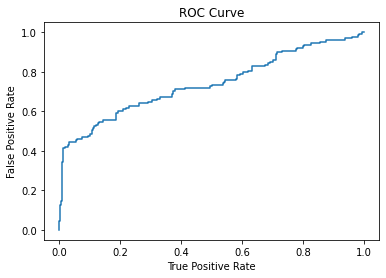

In [0]:
# Plotting the ROC curve.
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel("False Positive Rate")
plt.xlabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()